![](https://kh-kim.github.io/nlp_with_deep_learning_blog/assets/images/1-10/02-intuition.png)
* 검은 선: GD, 전체 데이터셋 Gradient, 빨간 선: SGD, 미니배치 Gradient
* 편향(bias)가 생김
* 즉 미니배치를 통해 구성한 손실함수는 실제 전체 데이터셋의 손실함수와 모양이 다름
* 미니배치 손실함수를 미분하면 얻을 수 있는 Gradient의 방향, 크기가 다를 수 있음
* 이 미니배치의 다른 Gradient를 빨간 선으로 나타냄

* 미니배치 크기에 따라 실제 Gradient에 비해서 mini-batch gradient가 왜곡되는 정도가 바뀜
* mini-batch가 클수록 Gradient는 실제 Gradient와 비슷할 확률이 높음


# Mini-batch크기에 따른 SGD
* 미니배치가 데이터셋의 크기에 점점 가까워지면: SGD와 GD의 Gradient 방향이 비슷해짐
* mini-batch가 점점1에 가까워지면 -> random sampling mini-batch는 전체 데이터셋과 달라 편향을 가질 가능성 높아짐, 노이즈 생김, 학습 저해
* 보통 256에서 시작
</br>

## mini-batch 크기에 따른 parameter update 횟수
* 한 epoch 내의 parameter 업데이트 횟수는 iteration 횟수와 같음
* 즉 iteration이 많을수록 학습 기회 많아짐.
* iteration횟수 줄이되 Learning-rate를 크게 잡아 파라미터가 업데이트 되는 양을 늘릴 수 있음


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [12]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

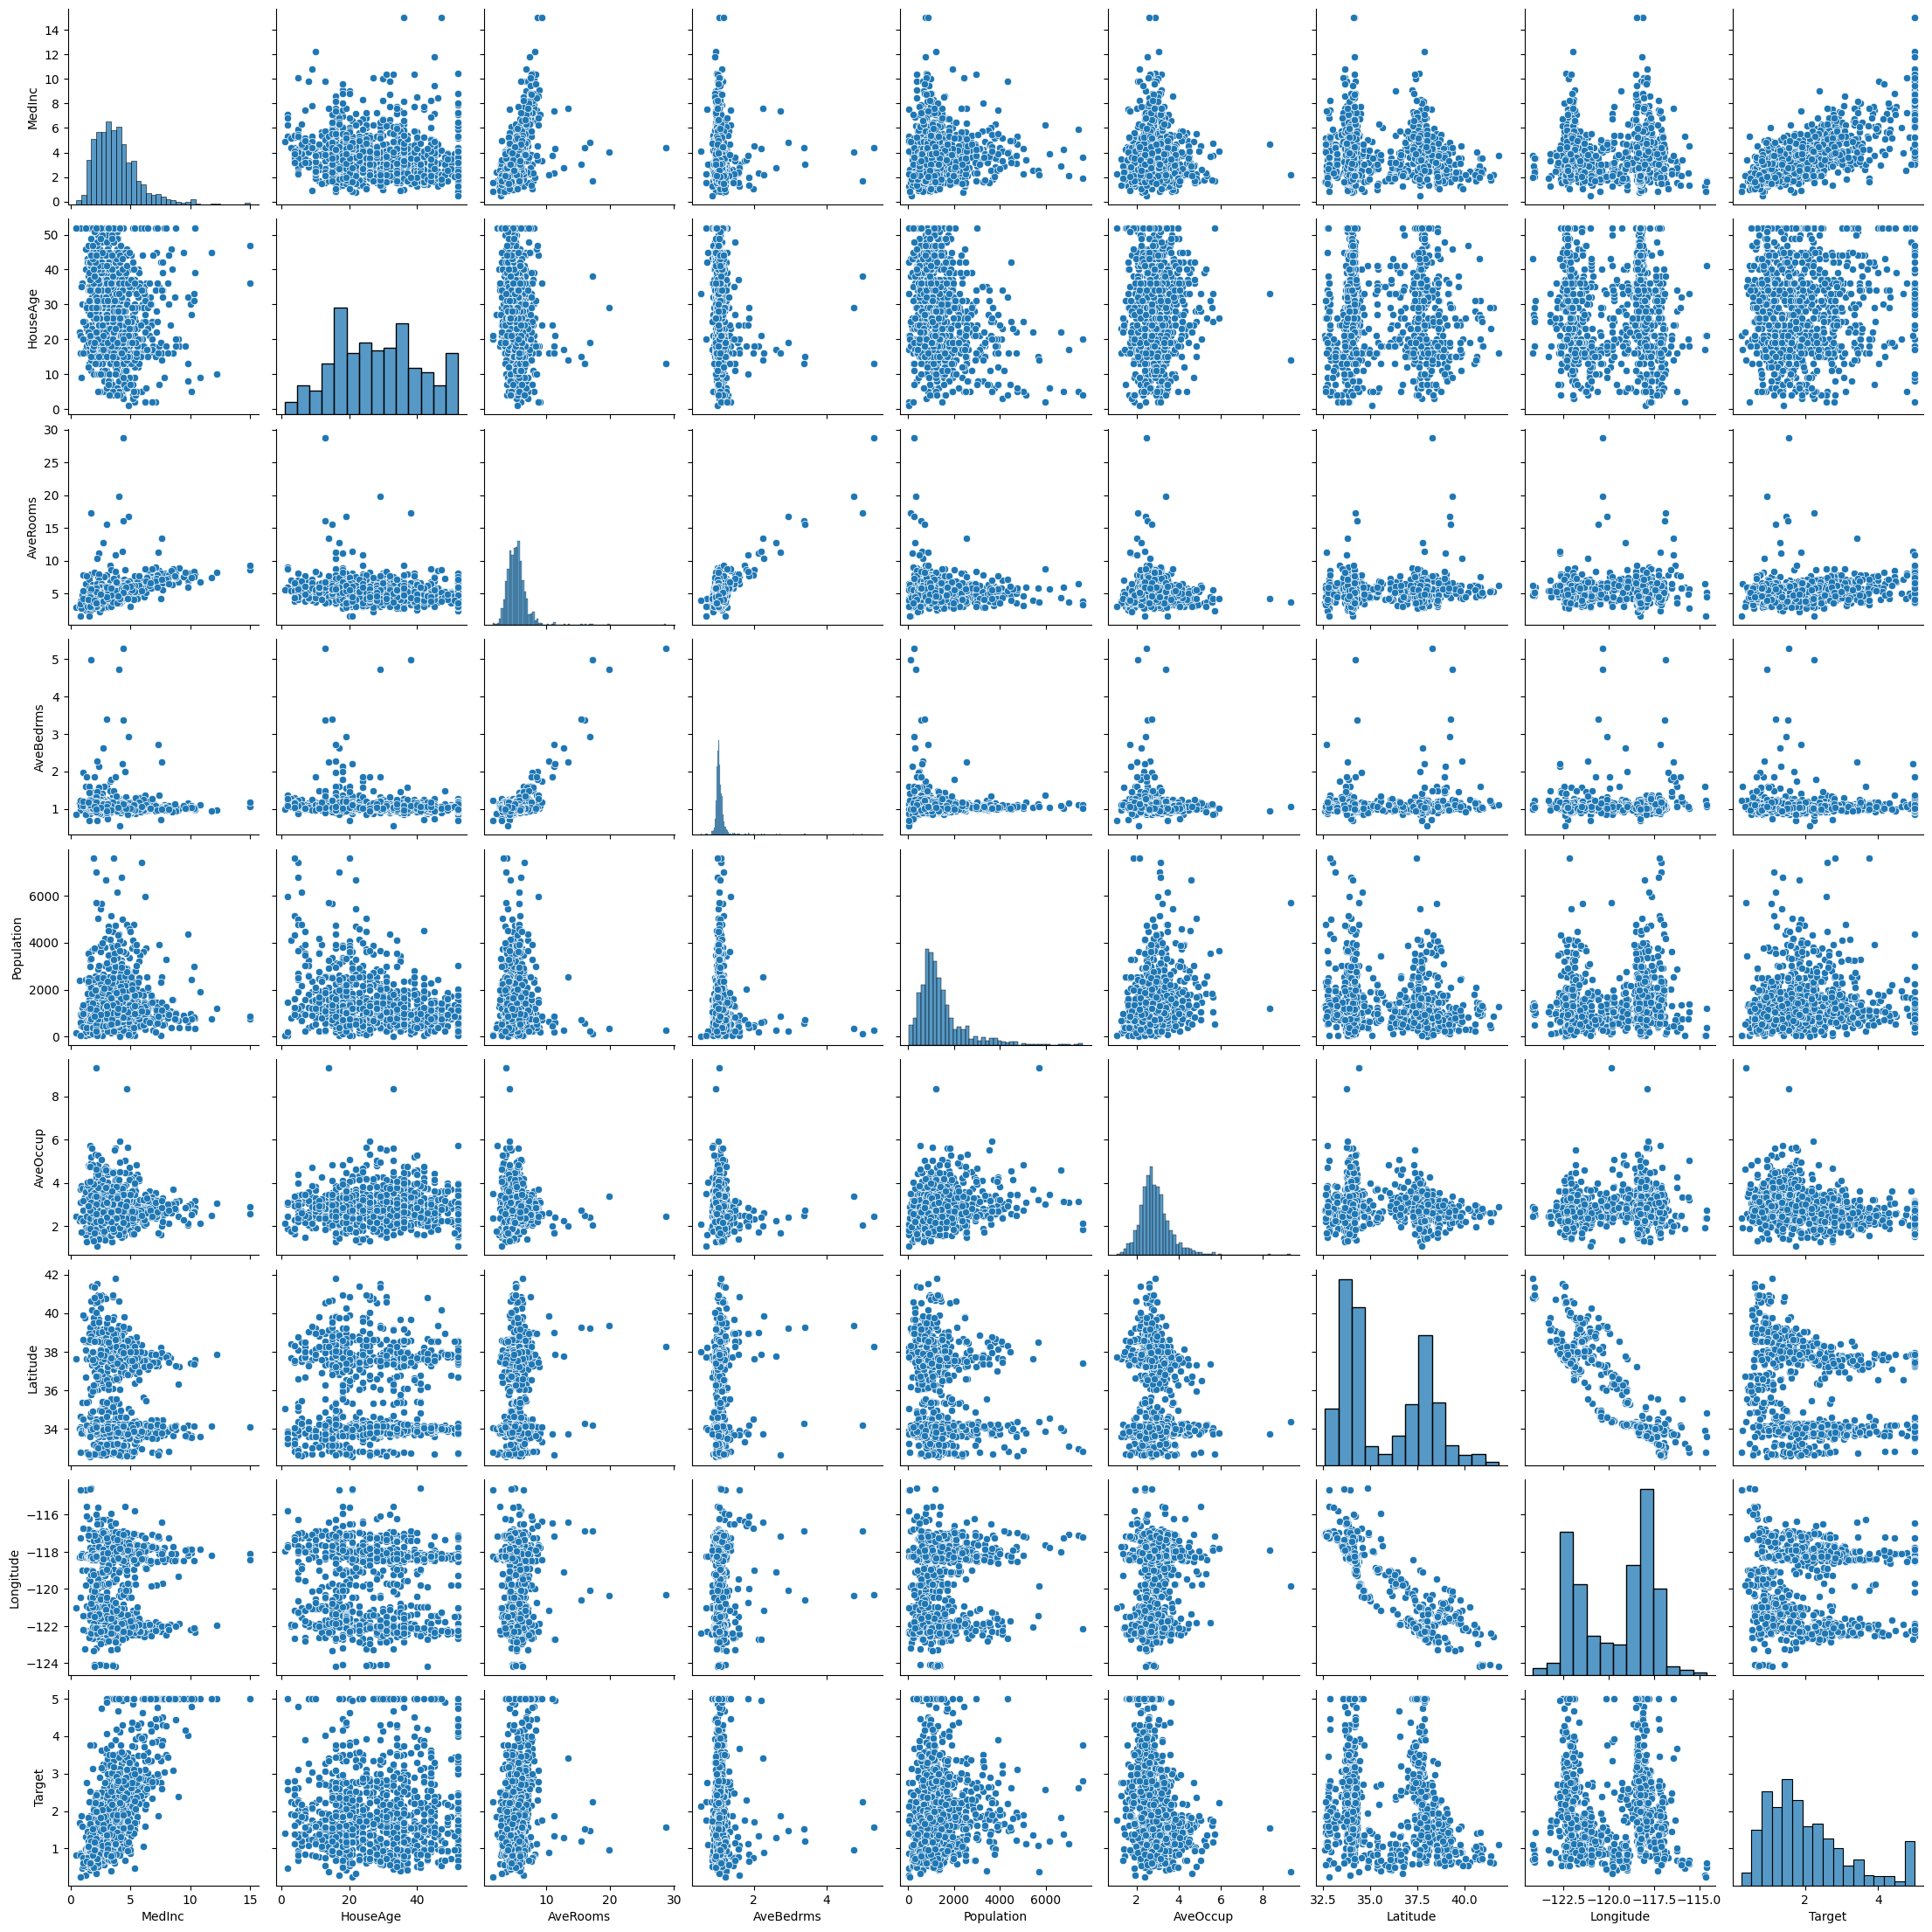

In [17]:
sns.pairplot(df.sample(1000))

In [20]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

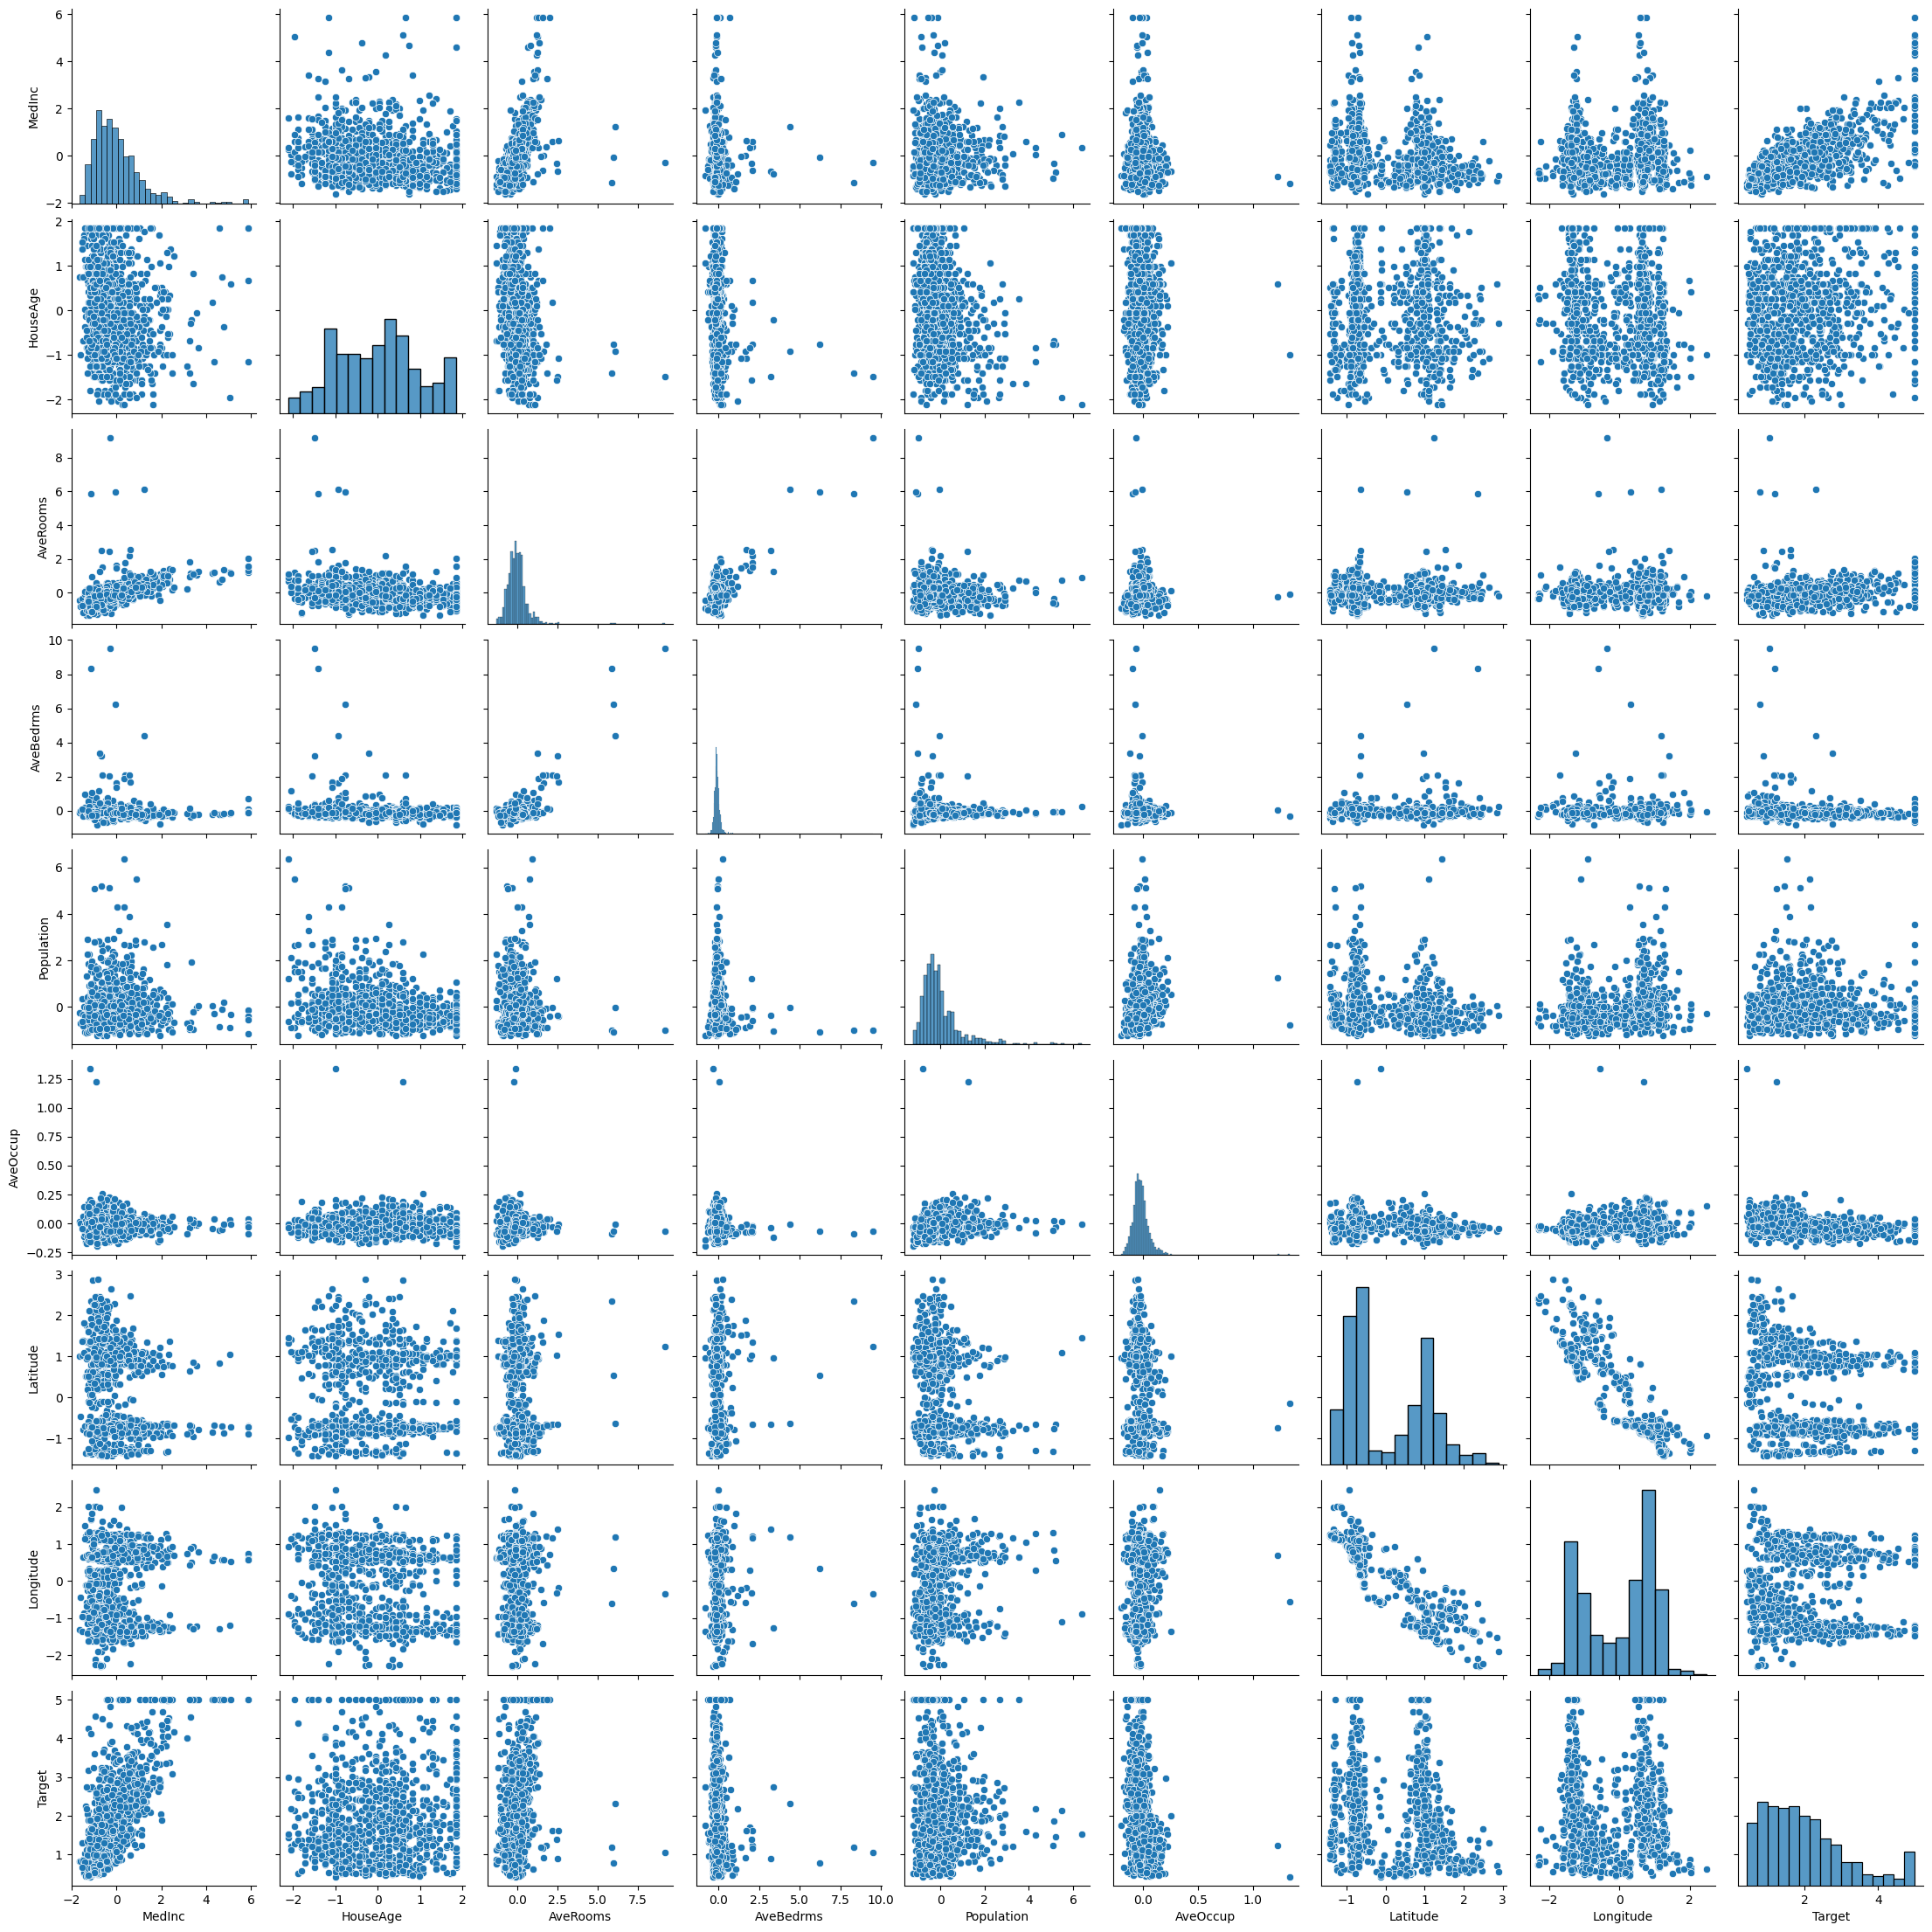

In [21]:
sns.pairplot(df.sample(1000))
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [37]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
data = torch.from_numpy(df.values).float()

print(data.shape)

torch.Size([20640, 9])


In [39]:
# 데이터를 torch 텐서화 한 후 x, y로 변환
x = data[:, :-1].to(device)
y = data[:, -1:].to(device)

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [40]:
n_epochs = 200000
print_interval = 10000
learning_rate = 1e-2
batch_size = 256

* nn.Sequential 클래스를 활용하여 DNN 구성
* 첫 번째와 마지막 Linear layer는 실제 데이터셋 텐서 x의 크기(8)와 y의 크기(1)를 입출력 크기로 갖도록 정해줌
* 내부의 선형 계층들은 서로 입출력 크기가 호환되도록 되어있음

In [43]:
from torchsummary import summary
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
).to(device)

summary(model, x.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 20640, 6]              54
         LeakyReLU-2             [-1, 20640, 6]               0
            Linear-3             [-1, 20640, 5]              35
         LeakyReLU-4             [-1, 20640, 5]               0
            Linear-5             [-1, 20640, 4]              24
         LeakyReLU-6             [-1, 20640, 4]               0
            Linear-7             [-1, 20640, 3]              15
         LeakyReLU-8             [-1, 20640, 3]               0
            Linear-9             [-1, 20640, 1]               4
Total params: 132
Trainable params: 132
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.63
Forward/backward pass size (MB): 5.83
Params size (MB): 0.00
Estimated Total Size (MB): 6.46
---------------------------------------------------

In [44]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

* 기존에는 for문 하나만 있었지만 iteration이 추가되어 하나가 더 생김
* 바깥 for문: 최대 n_epochs, 
* 안쪽 for문: 미니배치feed-forwarding, 역전파, 경사하강 수행
* 안쪽 for문에서 매 epoch마다 dataset을 섞어(shuffling) 미니 배치로 나눔
* **입력텐서 x와 출력텐서 y를 각각 따로 셔플링을 하지 않고 동일하게 섞어야함**
</br></br></br>

# 미니배치 반복문 과정
1. randperm 함수를 통해 새로운 데이터셋 인덱스 순서를 정함
2. index_select함수를 통해서 임의의 인덱스 순서대로 데이터셋을 섞음
3. split함수를 활용하여 원하는 배치사이즈로 tensor를 나누어주면 minibatch를 만드는 작업이 끝남
4. y_hat이라는 빈 리스트를 만들어 미니배치마다 y_hat_i 변수에 feedforwarding 결과가 나오면 y_hat에 차례대로 저장함
5. 마지막 epoch가 끝나면 y_hat 리스트를 torch.cat 함수로 붙여 하나의 텐서로 만든 후 정답 비교

In [45]:
indices = torch.randperm(x.size(0))
indices

tensor([14982, 18359,  7807,  ..., 11611,  4459,  8370])

In [53]:
for i in range(n_epochs):
    # Shuffle the index to feed_forward.
    # 데이터 사이즈입력 넣고 섞은 인덱스 추출
    indices = torch.randperm(x.size(0)).cuda()
    # 섞은 인덱스대로 데이터 순서 섞음
    x_ = torch.index_select(x, dim = 0, index = indices)
    y_ = torch.index_select(y, dim = 0, index = indices)
    # 섞인 데이터에서 배치사이즈만큼 나눔
    x_ = x_.split(batch_size,0)
    y_ = y_.split(batch_size,0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 메모리 누수를 막기 위해 이 작업 매우 중요!
        total_loss += float(loss)
        y_hat+=[y_hat_i]

    total_loss = total_loss/len(x_)
    if (i + 1) % print_interval == 0:
        print("epoch: {}/{}, loss = {:.4f}".format(i+1, n_epochs, total_loss))

y_hat = torch.cat(y_hat, dim = 0)
y = torch.cat(y_, dim = 0)
# |y_hat| = (total_size, output_dim)
# |y| = (total_size, output_dim)
        

epoch: 1/200000, loss = 2.2713
epoch: 2/200000, loss = 1.3314
epoch: 3/200000, loss = 1.3300
epoch: 4/200000, loss = 1.3297
epoch: 5/200000, loss = 1.3211
epoch: 6/200000, loss = 1.2835
epoch: 7/200000, loss = 1.1785
epoch: 8/200000, loss = 0.8874
epoch: 9/200000, loss = 0.6755
epoch: 10/200000, loss = 0.6243
epoch: 11/200000, loss = 0.5938
epoch: 12/200000, loss = 0.5661
epoch: 13/200000, loss = 0.5370
epoch: 14/200000, loss = 0.5119
epoch: 15/200000, loss = 0.4939
epoch: 16/200000, loss = 0.4812
epoch: 17/200000, loss = 0.4735
epoch: 18/200000, loss = 0.4677
epoch: 19/200000, loss = 0.4628
epoch: 20/200000, loss = 0.4594
epoch: 21/200000, loss = 0.4565
epoch: 22/200000, loss = 0.4529
epoch: 23/200000, loss = 0.4493
epoch: 24/200000, loss = 0.4463
epoch: 25/200000, loss = 0.4440
epoch: 26/200000, loss = 0.4400
epoch: 27/200000, loss = 0.4372
epoch: 28/200000, loss = 0.4340
epoch: 29/200000, loss = 0.4312
epoch: 30/200000, loss = 0.4294
epoch: 31/200000, loss = 0.4264
epoch: 32/200000,

: 

: 